In [1]:
import sys
sys.path.append('../')
from read_json import load_from_json
from parse_cedar_objects import parse_cedar_params, make_connection
import nengo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PROBE_ALL = False
SAVE_SIMULATION = False

In [3]:
objects, connections = load_from_json('../JSON/mental_imagery_extended.json')

Component Multiply 20 does not have 2 inputs, but 0!
The object Static Gain 23 does not have a source!


In [4]:
model = nengo.Network()

tau_factor = 1
# delete 3d neural fields to check their time consumption
nfs_3d = ['Attention', 'Perception']

with model:
    nengo_objects = {}
    # create the nodes
    for ob_key in objects:
        name, instance = parse_cedar_params(objects[ob_key])
        if instance.__class__.__name__ == 'NeuralField':
            instance.tau *= tau_factor
        instance.make_node()
        nengo_objects[name] = instance
    # create the connections
    for connection in connections:
        make_connection(connection[0][1], connection[1][1], nengo_objects)
        
#     for name in nfs_3d:
#         model.nodes.remove(nengo_objects[name].node)

#     for ob_key in nengo_objects:
#         if nengo_objects[ob_key].__class__.__name__ != 'NeuralField':
#             model.nodes.remove(nengo_objects[ob_key].node)
#         elif ob_key in nfs_3d:
#             model.nodes.remove(nengo_objects[ob_key].node)

In [5]:
# the list contains all nodes that are plotted in the plotting widget of the cedar architecture
objects_to_probe = ['Reference Behavior.intention node',      # Reference processes
                    'Reference Behavior.CoS node', 
                    'Reference Field & Reference Production Nodes.intention node',
                    'Reference Field & Reference Production Nodes.CoS node',
                    'Reference Memory Nodes & Color Field.intention node',
                    'Reference Memory Nodes & Color Field.CoS node', 
                    'Target Behavior.intention node',        # Target processes
                    'Target Behavior.CoS node', 
                    'Target Field & Target Production Nodes.intention node',
                    'Target Field & Target Production Nodes.CoS node',
                    'Reference Memory Nodes & Color Field 2.intention node',
                    'Reference Memory Nodes & Color Field 2.CoS node',
                    'Match Field.intention node', 
                    'Match Field.CoS node',
                    'Relational Behavior.intention node',   # Spatial processes
                    'Relational Behavior.CoS node',
                    'OC Field and Spatial Production Nodes  .intention node',
                    'OC Field and Spatial Production Nodes  .CoS node',
                    'Condition of  Dissatisfaction .intention node', 
                    'Condition of  Dissatisfaction .CoS node',
                    'Spatial Memory Nodes.intention node', 
                    'Spatial Memory nodes.CoS node',
                    'Colour',                              # Color attention                                
                    'Projection',                          # Attention (space)
                    'Indeterminent ',                      # Spatial scene representation
                    'Reference',                           # Reference
                    'Target',                              # Target
                    'Object-centered ',                    # Relational
                    'Reference Red Memory',                # Reference color memory
                    'Reference Blue Memory', 
                    'Reference Cyan Memory', 
                    'Reference Green Memory', 
                    'Reference Orange Memory', 
                    'To the left of Memory',               # Spatial relation memory
                    'To the Right of Memory', 
                    'Above Memory', 
                    'Below Memory', 
                    'Target Red Memory',                   # Target color memory
                    'Target Blue Memory', 
                    'Target Cyan Memory', 
                    'Target Green Memory', 
                    'Target Orange Memory', 
                    'Reference Red Production',            # Reference color production
                    'Reference Blue Production', 
                    'Reference Cyan Production', 
                    'Reference Green Production', 
                    'Reference Orange Production',
                    'To the left of Production',           # Spatial relation production
                    'To the Right of Production', 
                    'Above Production', 
                    'Below Production',
                    'Target Red Production',               # Target color production
                    'Target Blue Production', 
                    'Target Cyan Production', 
                    'Target Green Production', 
                    'Target Orange Production']

In [6]:
with model:
    probes = {}
    for key in nengo_objects:
        if not PROBE_ALL:
            if key in objects_to_probe:
                probes[key] = nengo.Probe(nengo_objects[key].node, sample_every=0.01)
        else:
            probes[key] = nengo.Probe(nengo_objects[key].node, sample_every=0.05)

In [7]:
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [8]:
# Supply sentence
nengo_objects['Reference: Blue'].strength = 5.1
nengo_objects['Reference: Blue'].active = True
nengo_objects['Target: Cyan'].active = True
nengo_objects['Spatial relation: Left'].active = True

sim.run_steps(int(500*tau_factor))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [9]:
# Activate imagine node
nengo_objects['Reference: Blue'].active = False
nengo_objects['Target: Cyan'].active = False
nengo_objects['Spatial relation: Left'].active = False
nengo_objects['Action: Imagine'].active = True

sim.run_steps(int(9500*tau_factor))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [10]:
sim.close()

In [11]:
# save simulation results
from datetime import datetime
import os 
timestamp = str(datetime.now()).rsplit('.',1)[0]
print(timestamp)

if SAVE_SIMULATION:
    os.mkdir('../simulation_data/%s' %timestamp)
    for ob_key in probes:
        file_name = ob_key.replace('/','_')
        np.save('../simulation_data/%s/%s_%s' %(timestamp, file_name, timestamp), sim.data[probes[ob_key]])

2019-10-22 17:05:11


# Plot color activation

In [12]:
def plot_2dneuralfield(nf_data, time_points, colorbar=False, title=None, save=False):
    plt.figure(figsize=(10, 5))
    # make title
    if title is None:
        plt.suptitle('Tau_factor %.2f' %tau_factor)
    else: 
        plt.suptitle('%s - Tau_factor %.2f' %(title, tau_factor))
    # plot 15 points in time 
    for i, time_point in enumerate(time_points):
        plt.subplot(3,5,i+1)
        plt.imshow(nf_data[time_point].reshape(50,50), cmap='jet')
        plt.title('%i ms' %(time_point*10))
        plt.xticks([])
        plt.yticks([])
        if colorbar:
            plt.colorbar()
    # save image    
    if save:
        if not os.path.isdir('../../images/%.2f' %tau_factor):
            os.mkdir('../../images/%.2f' %tau_factor)
        plt.savefig('../../images/%.2f/%s_%.2f_%s.png' %(tau_factor,
                                                         title,
                                                         tau_factor,
                                                         timestamp))
        
    plt.show()
    
def plot_1dneuralfield(nf_data, time_points, title=None, save=False):
    plt.figure(figsize=(12,6))
    min = np.min(nf_data)
    max = np.max(nf_data)
    dif = max-min
    # make title
    if title is None:
        plt.suptitle('Tau_factor %.2f' %tau_factor)
    else: 
        plt.suptitle('%s - Tau_factor %.2f' %(title, tau_factor))
    
    for i, tp in enumerate(time_points):
        plt.subplot(3,5,i+1)
        plt.title('%i ms' %(tp*10))
        plt.plot(nf_data[tp])
        plt.ylim(min-0.1*dif, max+0.1*dif)
        
    plt.tight_layout(rect=(0,0,1,0.96))
    # save image
    if save:
        if not os.path.isdir('../../images/%.2f' %tau_factor):
            os.mkdir('../../images/%.2f' %tau_factor)
        plt.savefig('../../images/%.2f/%s_%.2f_%s.png' %(tau_factor,
                                                         title,
                                                         tau_factor,
                                                         timestamp))
    plt.show()
    
def plot_3dneuralfield(nf_data, time_points):
    # length of time_points maximally 6
    plt.figure(figsize=(15,9))
    
    # create 6 plots of 7*8 images
    cols = 3*8+2
    rows = 2*7+2
    for i, tp in enumerate(time_points):
        min, max = np.min(nf_data[tp]), np.max(nf_data[tp])
        print('Min and Max values: %.4f  %.4f' %(min, max))
        tp_plot = (i//3)*8*cols + (i%3)*9 + 1
        for j in range(50):
            ind_plot = j//8*cols + (j%8)
            plt.subplot(rows, cols, tp_plot+ind_plot)
            plt.imshow(nf_data[tp,:,:,j], vmin=min, vmax=max, cmap='jet')
            plt.xticks([])
            plt.yticks([])
            if j == 3:
                plt.title("%i ms" %(tp*50))


In [13]:
# for tau_factor 0.05 show every third step, for other tau_factors show a multiple 
# thereof
num_samples = sim.data[probes['Reference Blue Memory']].shape[0]
print('Number of samples:', num_samples)

if num_samples > 30:
    stepsize = 3*int(tau_factor/0.05)
    tps_1d = np.arange(0,num_samples, stepsize)[-15:]
    time_points = np.arange(0,num_samples, stepsize)[-15:]

    print('Difference between accurate points and the ones used:', 
          3*tau_factor/0.05 - stepsize)
else:
    tps_1d = np.arange(0, num_samples)[-15:]
    time_points = np.arange(0, num_samples)[-15:]
print('tps_1d: \n', tps_1d)

from cedar_modules import AbsSigmoid
sigmoid = AbsSigmoid()

Number of samples: 1000
Difference between accurate points and the ones used: 0.0
tps_1d: 
 [120 180 240 300 360 420 480 540 600 660 720 780 840 900 960]


In [14]:
tps_1d

array([120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840,
       900, 960])

## Color and Relation fields 0-dimensional

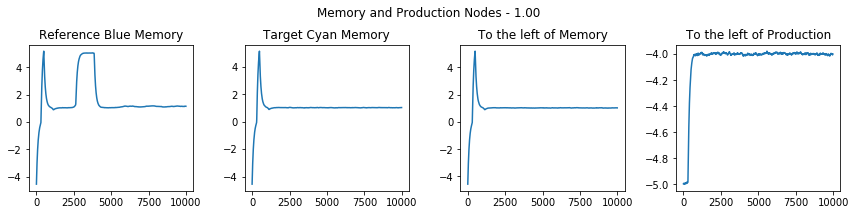

In [15]:
x = np.arange(0, num_samples) * 10

plot_1d = ['Reference Blue Memory', 'Target Cyan Memory', 'To the left of Memory', 
           'To the left of Production', 'Static Gain 84', 'Imagine (Build mental model)',
           'Wipe Node', 'node 2', 'node 3', 'Precondition Node T-W', 'Precondition Node S-W',
           'Precondition Node R-W', 'Static Gain 4', 'Static Gain 44', 'Static Gain 21',
           'Static Gain 45', 'Static Gain 57']

half = x.shape[0]//2
if not PROBE_ALL:
    plot_1d = [elem for elem in plot_1d if elem in objects_to_probe]

if len(plot_1d) == 4:
    plt.figure(figsize=(12,3))
    rows = 1
else:
    plt.figure(figsize=(12,15))
    rows = 5
plt.suptitle('Memory and Production Nodes - %.2f' %tau_factor)
for i, name in enumerate(plot_1d):
    plt.subplot(rows,4,i+1)
    plt.plot(x, sim.data[probes[name]])
    name_split = name.rsplit('.',1)
    if len(name_split) > 1:
        plt.title(name_split[1])
    else:
        plt.title(name)

plt.tight_layout(rect=(0,0,1,0.93))
# save
if not os.path.isdir('../../images/%.2f' %tau_factor):
    os.mkdir('../../images/%.2f' %tau_factor)
plt.savefig('../../images/%.2f/Memory and Production Nodes_%.2f_%s.png' %(tau_factor,
                                                                          tau_factor,
                                                                          timestamp))
plt.show()

## Group Reference Behavior

## Color

(1000, 50)


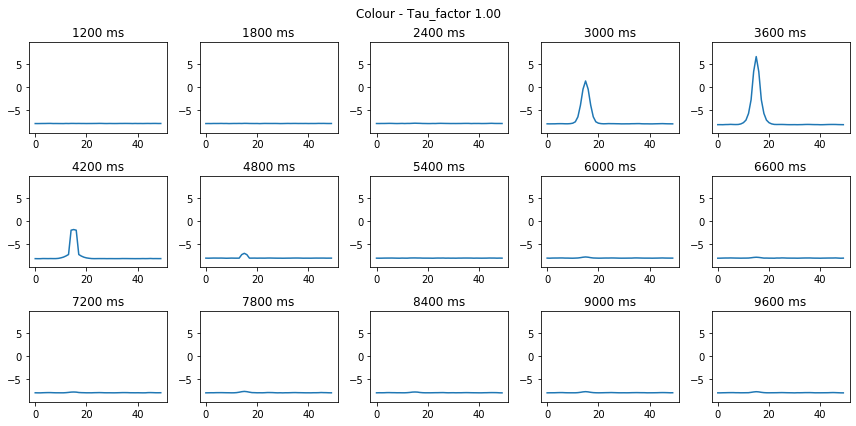

In [16]:
colour_data = sim.data[probes['Colour']]


plot_1dneuralfield(colour_data, tps_1d, 'Colour', True)

## Spatial scene 

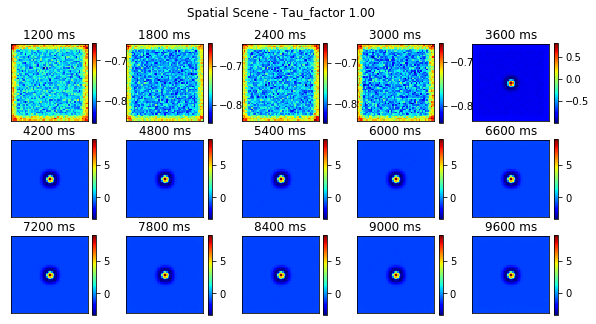

In [17]:
spatial_scene = sim.data[probes['Indeterminent ']]

plot_2dneuralfield(spatial_scene, time_points, True, 'Spatial Scene', True)

## Object-centered

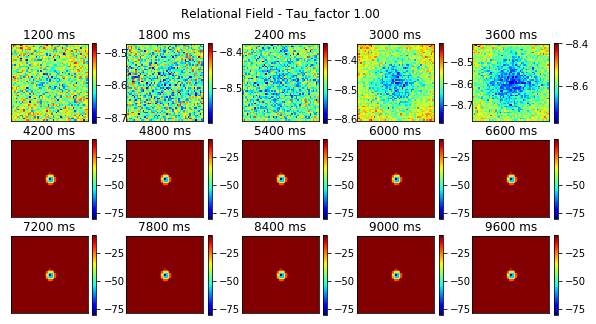

In [18]:
# Object-centered = relational field in the Plotting widget
object_centered_data = sim.data[probes['Object-centered ']]

plot_2dneuralfield(object_centered_data, time_points, True, 'Relational Field', True)

## Target

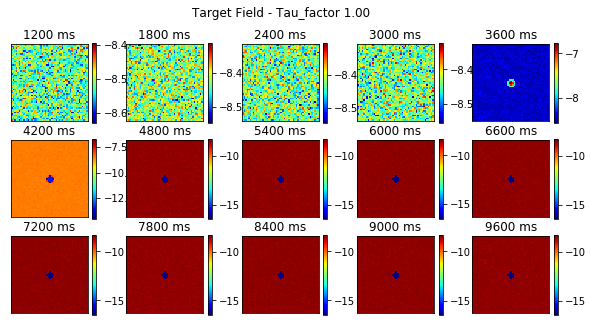

In [19]:
target = sim.data[probes['Target']]

plot_2dneuralfield(target, time_points, True, 'Target Field', True)

## Reference

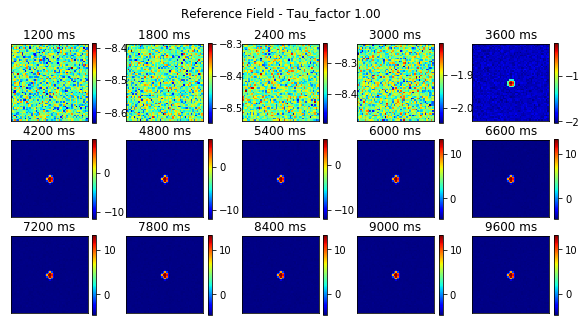

In [20]:
reference_data = sim.data[probes['Reference']]

plot_2dneuralfield(reference_data, time_points, True, 'Reference Field', True)

# 0-dimensional Group nodes

## Group Target Behavior

In [21]:
if PROBE_ALL:
    target_behavior_nodes = ['Target Behavior.intention node',
               'Target Behavior.new StaticGain 6', 'Target Behavior.new Static Gain 4',
               'Target Behavior.new Static Gain 12', 'Target Behavior.new Static Gain 15',
               'Target Behavior.new Static Gain 25', 'Target Behavior.new Static Gain 26',
               'Target Behavior.new Static Gain 27', 'Target Behavior.new StaticGain 2',
               'Target Behavior.CoS node', 'Target Behavior.new Static Gain 5', 
                'Target Behavior.new Static Gain 18']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(target_behavior_nodes):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Reference Behavior

In [22]:
if PROBE_ALL: 
    ref_behavior_nodes = ['Reference Behavior.intention node', 'Reference Behavior.new Static Gain 10',
                         'Reference Behavior.new StaticGain 6', 'Reference Behavior.new Static Gain 19',
                         'Reference Behavior.new Static Gain 20', 'Reference Behavior.new Static Gain 31',
                         'Reference Behavior.new Static Gain 21', 'Reference Behavior.new StaticGain 2',
                         'Reference Behavior.CoS node', 'Reference Behavior.new Static Gain 5',
                         'Reference Behavior.new Static Gain 16']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(ref_behavior_nodes):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Target Field & Target Production Nodes

In [23]:
if PROBE_ALL:
    group_names = ['Target Field & Target Production Nodes.new StaticGain 6',
                   'Target Field & Target Production Nodes.new StaticGain 2',
                  'Target Field & Target Production Nodes.intention node',
                  'Target Field & Target Production Nodes.Static Gain 47',
                  'Target Field & Target Production Nodes.Projection 12',
                  'Target Field & Target Production Nodes.Static Gain 22',
                  'Target Field & Target Production Nodes.CoS node',
                  'Target Field & Target Production Nodes.Static Gain 40',
                  'Target Field & Target Production Nodes.Boost Target',
                  'Target Field & Target Production Nodes.Static Gain 39',
                  'Target Field & Target Production Nodes.Static Gain 46',
                  'Target Field & Target Production Nodes.new Static Gain 2']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(group_names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Reference Field & Reference Production Nodes

In [24]:
if PROBE_ALL:
    names = ['Reference Field & Reference Production Nodes.new StaticGain 6',
            'Reference Field & Reference Production Nodes.new StaticGain 2',
            'Reference Field & Reference Production Nodes.intention node',
            'Reference Field & Reference Production Nodes.Static Gain 47',
            'Reference Field & Reference Production Nodes.Projection 12',
            'Reference Field & Reference Production Nodes.Static Gain 22',
            'Reference Field & Reference Production Nodes.CoS node',
            'Reference Field & Reference Production Nodes.Static Gain 40',
            'Reference Field & Reference Production Nodes.Boost Reference',
            'Reference Field & Reference Production Nodes.Static Gain 39',
            'Reference Field & Reference Production Nodes.Static Gain 46',
            'Reference Field & Reference Production Nodes.new Static Gain 2']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Relational Behavior

In [25]:
if PROBE_ALL:
    names = ['Relational Behavior.new StaticGain 6',
            'Relational Behavior.new Static Gain 3',
            'Relational Behavior.new Static Gain 11',
            'Relational Behavior.new Static Gain 22',
            'Relational Behavior.new Static Gain 23',
            'Relational Behavior.new Static Gain 24',
            'Relational Behavior.new Static Gain 37',
            'Relational Behavior.new StaticGain 2',
            'Relational Behavior.intention node',
            'Relational Behavior.CoS node',
            'Relational Behavior.new Static Gain 5']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group OC Field and Spatial Production Nodes

In [26]:
if PROBE_ALL:
    names = ['OC Field and Spatial Production Nodes  .new StaticGain 6',
             'OC Field and Spatial Production Nodes  .new StaticGain 2',
             'OC Field and Spatial Production Nodes  .intention node',
             'OC Field and Spatial Production Nodes  .Static Gain 51',
             'OC Field and Spatial Production Nodes  .Projection 27',
             'OC Field and Spatial Production Nodes  .Static Gain 52',
             'OC Field and Spatial Production Nodes  .CoS node',
             'OC Field and Spatial Production Nodes  .new Static Gain 6',
             'OC Field and Spatial Production Nodes  .Static Gain 50',
             'OC Field and Spatial Production Nodes  .Static Gain 48',
             'OC Field and Spatial Production Nodes  .Boost OCF',
             'OC Field and Spatial Production Nodes  .Static Gain 49']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Condition of Dissatisfaction

In [27]:
if PROBE_ALL:
    names = ['Condition of  Dissatisfaction .new StaticGain 6', 'Condition of  Dissatisfaction .new StaticGain 2',
             'Condition of  Dissatisfaction .intention node', 'Condition of  Dissatisfaction .Static Gain 40',
             'Condition of  Dissatisfaction .node', 'Condition of  Dissatisfaction .Static Gain 37',
             'Condition of  Dissatisfaction .CoS node', 'Condition of  Dissatisfaction .Static Gain 34']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Spatial Memory Nodes

In [28]:
if PROBE_ALL:
    names = ['Spatial Memory Nodes.new StaticGain 6', 'Spatial Memory Nodes.new StaticGain 2',
             'Spatial Memory Nodes.intention node', 'Spatial Memory Nodes.Static Gain 47',
             'Spatial Memory Nodes.CoS node', 'Spatial Memory Nodes.Static Gain 40']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Reference Memory Nodes & Color Field

In [29]:
if PROBE_ALL:
    names = ['Reference Memory Nodes & Color Field.new StaticGain 6',
             'Reference Memory Nodes & Color Field.new StaticGain 2',
             'Reference Memory Nodes & Color Field.intention node',
             'Reference Memory Nodes & Color Field.Projection 15',
             'Reference Memory Nodes & Color Field.Static Gain 60',
             'Reference Memory Nodes & Color Field.CoS node',
             'Reference Memory Nodes & Color Field.Static Gain 40',
             'Reference Memory Nodes & Color Field.Static Gain 59',
             'Reference Memory Nodes & Color Field.Boost Color Field',
             'Reference Memory Nodes & Color Field.Static Gain 58']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Reference Memory Nodes & Color Field 2

In [30]:
if PROBE_ALL:
    names = ['Reference Memory Nodes & Color Field 2.new StaticGain 6',
             'Reference Memory Nodes & Color Field 2.new StaticGain 2',
             'Reference Memory Nodes & Color Field 2.intention node',
             'Reference Memory Nodes & Color Field 2.Projection 15',
             'Reference Memory Nodes & Color Field 2.Static Gain 60',
             'Reference Memory Nodes & Color Field 2.CoS node',
             'Reference Memory Nodes & Color Field 2.Static Gain 40',
             'Reference Memory Nodes & Color Field 2.Static Gain 59',
             'Reference Memory Nodes & Color Field 2.Boost Color Field',
             'Reference Memory Nodes & Color Field 2.Static Gain 58']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()

## Group Match Field

In [31]:
if PROBE_ALL:
    names = ['Match Field.new StaticGain 6', 'Match Field.new StaticGain 2', 
             'Match Field.intention node', 'Match Field.Static Gain 47', 'Match Field.Projection 12',
             'Match Field.Static Gain 22', 'Match Field.CoS node', 'Match Field.Static Gain 40',
             'Match Field.Boost Match Field', 'Match Field.Static Gain 39', 'Match Field.new Static Gain 2']

    plt.figure(figsize=(15,12))
    for i, name in enumerate(names):
        plt.subplot(4,5,i+1)
        plt.plot(x, sim.data[probes[name]])
        name_split = name.rsplit('.',1)
        if len(name_split) > 1:
            plt.title(name_split[1])
        else:
            plt.title(name)

    plt.tight_layout()
    plt.show()